### Problem statement
An important deep learning problem is detecting lung disease with a publicly available chest X-ray dataset. This task involves training a model to classify different lung diseases, such as pneumonia, tuberculosis, and COVID-19, from chest X-ray images. It is both clinically relevant and technically challenging, offering rich opportunities for exploratory data analysis (EDA) and model analysis.

### Dataset Information
The NIH Chest X-ray dataset is publicly available on platforms like [Kaggle](https://www.kaggle.com/datasets/nih-chest-xrays/data) and includes a large collection of labeled chest X-ray images with different lung diseases. The dataset typically contains thousands of X-ray images labeled as "Normal," "Pneumonia," "Tuberculosis," and sometimes other diseases. This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_xray_df = all_xray_df.loc[:, ~all_xray_df.columns.str.contains('^Unnamed')]
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/kaggle/input/data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
65357,00016142_005.png,Effusion,5,16142,19,M,AP,3056,2544,0.139,0.139,/kaggle/input/data/images_008/images/00016142_...
9094,00002380_002.png,No Finding,2,2380,44,M,AP,2500,2048,0.168,0.168,/kaggle/input/data/images_002/images/00002380_...
68199,00016821_004.png,Effusion,4,16821,35,F,AP,2500,2048,0.168,0.168,/kaggle/input/data/images_008/images/00016821_...


### Exploratory data analysis
Now that I have the data loaded, I will look at label distributions. Analysis of results to follow.

        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  \
0                        0.143  0.143   
1                     

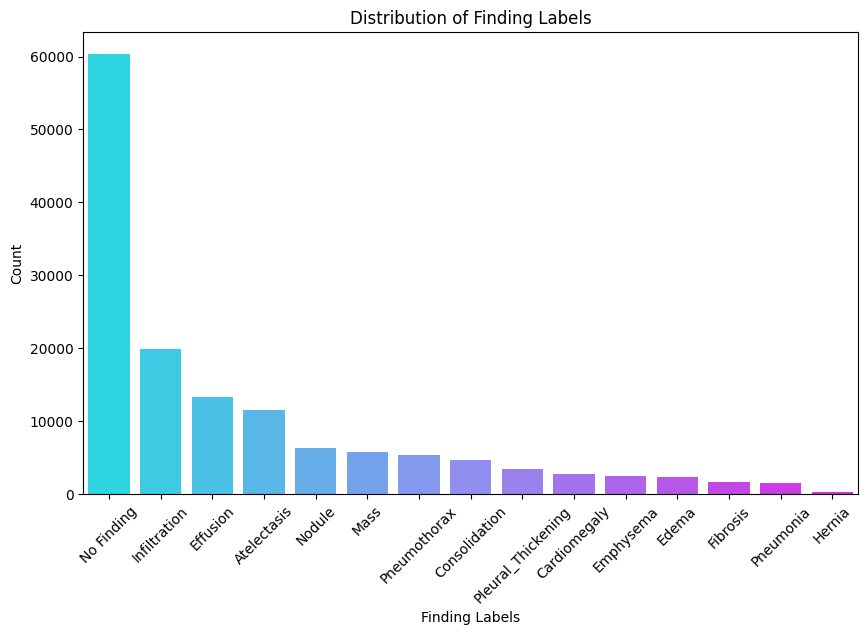

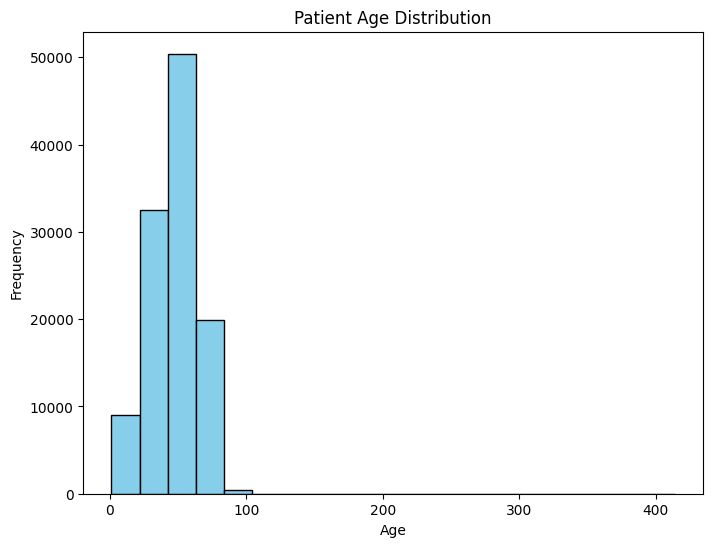

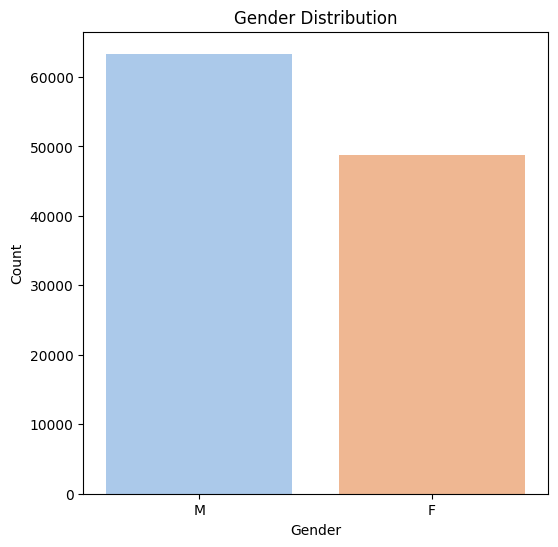

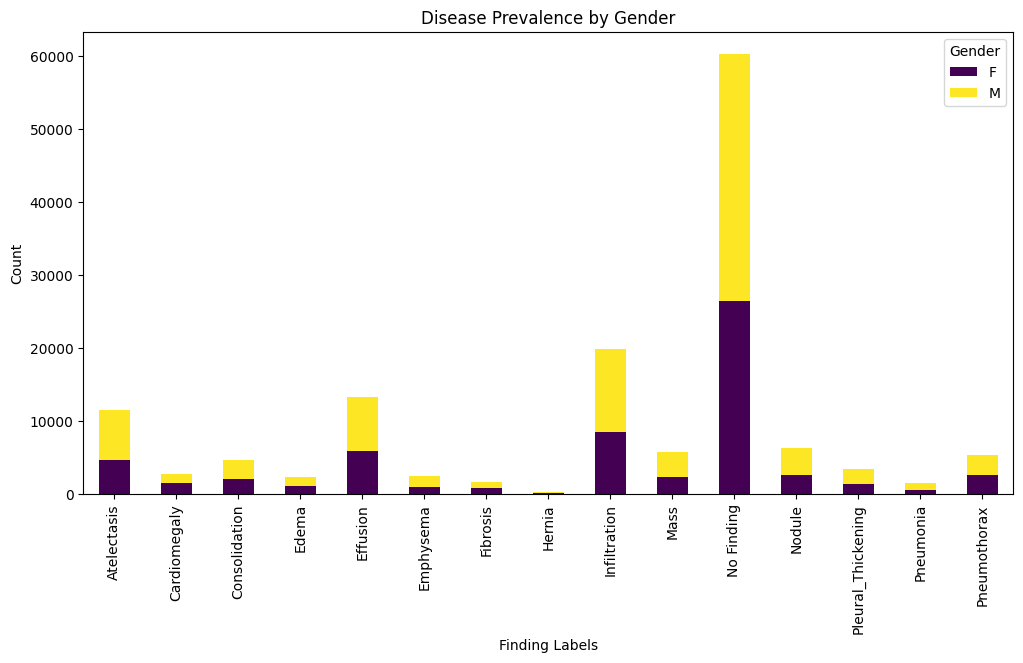

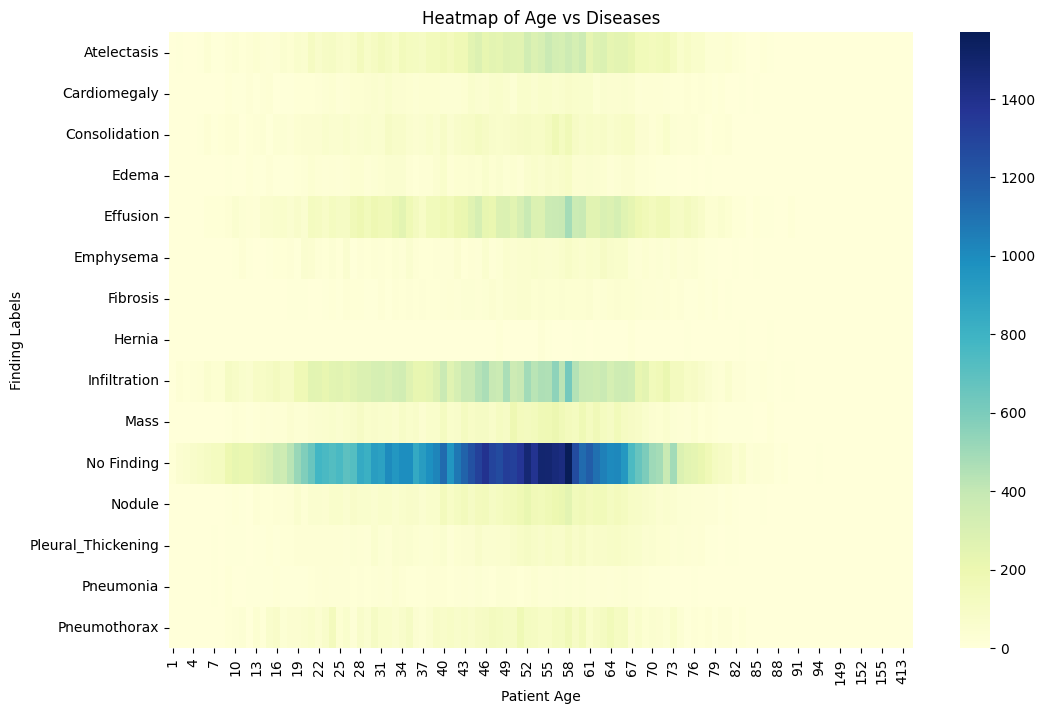

In [2]:
# Displaying the first few rows of the dataaset to understand its structure
print(all_xray_df.head())

# --- Step 1: Distribution of Finding Labels ---
# Splitting multi-label findings into separate rows for better analysis
all_xray_df["Finding Labels"] = all_xray_df["Finding Labels"].apply(lambda x: x.split("|"))
findings_flat = [finding for findings in all_xray_df["Finding Labels"] for finding in findings]
findings_df = pd.DataFrame(findings_flat, columns=["Finding"])
finding_counts = findings_df["Finding"].value_counts()

# Plotting Finding Labels distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=finding_counts.index, y=finding_counts.values, palette="cool")
plt.xticks(rotation=45)
plt.title("Distribution of Finding Labels")
plt.xlabel("Finding Labels")
plt.ylabel("Count")
plt.show()

# --- Step 2: Patient Age Distribution ---
plt.figure(figsize=(8, 6))
plt.hist(all_xray_df["Patient Age"], bins=20, color="skyblue", edgecolor="black")
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# --- Step 3: Gender Distribution ---
plt.figure(figsize=(6, 6))
sns.countplot(data=all_xray_df, x="Patient Gender", palette="pastel")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# --- Step 4: Disease Prevalence by Gender ---
# Expanding the Finding Labels for multi-label conditions
all_xray_df = all_xray_df.explode("Finding Labels")
gender_disease = all_xray_df.groupby(["Patient Gender", "Finding Labels"]).size().unstack()

# Plotting
gender_disease.T.plot(kind="bar", figsize=(12, 6), stacked=True, colormap="viridis")
plt.title("Disease Prevalence by Gender")
plt.xlabel("Finding Labels")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.show()

# --- Step 5: Heatmap for Age and Diseases ---
# Aggregating data for heatmap visualization
age_disease = all_xray_df.groupby(["Patient Age", "Finding Labels"]).size().unstack(fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(age_disease.T, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Heatmap of Age vs Diseases")
plt.xlabel("Patient Age")
plt.ylabel("Finding Labels")
plt.show()


### EDA Findings
#### Label Distribution
The "No Finding" is overwhelmingly represented in the dataset. This dominance indicates a significant class imbalance. Other disease labels, such as pneumonia, cardiomegaly, or edema, have relatively fewer samples, some of which might be sparse. Class imbalance is problematic for machine learning models, as they may become biased toward predicting the majority class ("No Finding") while neglecting minority classes. I can use class weights in the loss function to penalize misclassification of minority classes more heavily.

#### Gender Representation
The dataset has more male patients compared to female patients. The difference is notable but not excessively imbalanced, which suggests that both genders are reasonably represented in the dataset.

#### Disease prevelance by Gender
The majority of the records fall under the "No Finding" category for both males and females. Certain diseases may lead to gender-specific biases during model training. The model might learn to predict diseases more accurately for males due to higher representation. I can use techniques like oversampling (for minority disease labels) or applying class weights in the loss function to mitigate this imbalance.

### Heatmap of Age vs Disease
The "No Finding" label shows the highest intensity, with the peak concentrated around middle-aged patients (roughly 40–60 years old). This aligns with the overall dataset class imbalance and demographic distribution. I will incorporate age as an auxiliary feature for model training. Some diseases are age-dependent, and this feature may help improve prediction accuracy.

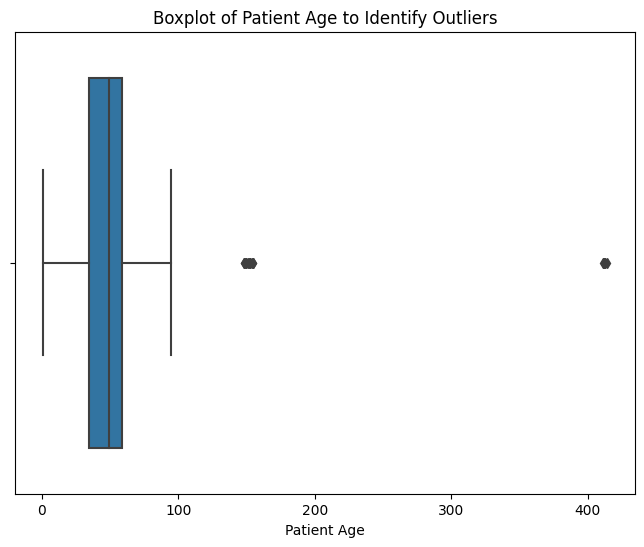

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


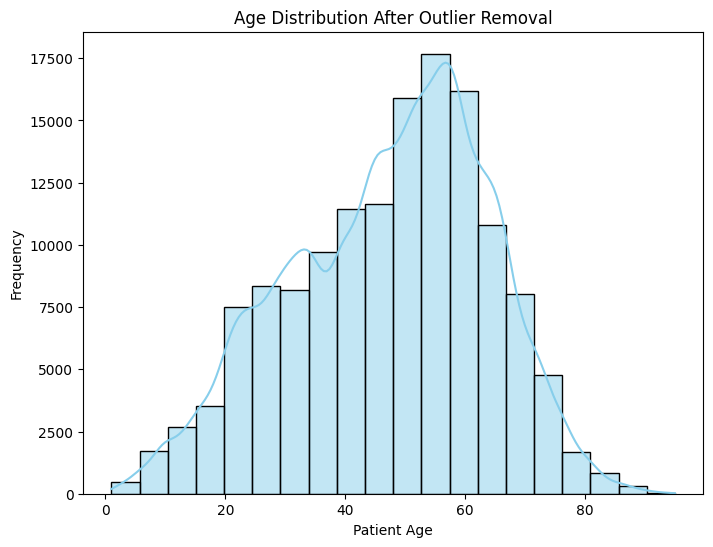

Original Dataset Size: 141537 rows
Dataset Size After Outlier Removal: 141517 rows


In [3]:
# Visualizing Age Outliers with a Boxplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x=all_xray_df["Patient Age"])
plt.title("Boxplot of Patient Age to Identify Outliers")
plt.show()

# Step 1: Define a reasonable age range
# Assuming valid ages are between 0 and 100 years
valid_age_range = (0, 100)

# Step 2: Remove outliers outside the valid age range
outlier_removed_df = all_xray_df[(all_xray_df["Patient Age"] >= valid_age_range[0]) & 
                                 (all_xray_df["Patient Age"] <= valid_age_range[1])]

# Step 3: Check the distribution after outlier removal
plt.figure(figsize=(8, 6))
sns.histplot(outlier_removed_df["Patient Age"], bins=20, kde=True, color="skyblue")
plt.title("Age Distribution After Outlier Removal")
plt.xlabel("Patient Age")
plt.ylabel("Frequency")
plt.show()

# Step 4: Print before and after statistics
print(f"Original Dataset Size: {all_xray_df.shape[0]} rows")
print(f"Dataset Size After Outlier Removal: {outlier_removed_df.shape[0]} rows")


### Box plot analysis
There are extreme outliers well above the normal human age range (e.g., values near 200 and 400 years). These values are biologically implausible and likely due to data entry errors. I've cleaned out these outliers.

### Final data cleaning

In [13]:
# Check for missing values in the dataset
print("Missing Values Before Handling:")
print(all_xray_df.isnull().sum())

# Step 1: Handle missing values in Finding Labels
# Replace missing Finding Labels with "Unknown"
if "Finding Labels" in all_xray_df.columns:
    all_xray_df["Finding Labels"].fillna("Unknown", inplace=True)

# Step 2: Handle missing values in Patient Age
# Replace missing Patient Age with the median age
if "Patient Age" in all_xray_df.columns:
    median_age = all_xray_df["Patient Age"].median()
    all_xray_df["Patient Age"].fillna(median_age, inplace=True)

# Step 3: Handle missing values in Patient Gender
# Replace missing Patient Gender with the mode (most common gender)
if "Patient Gender" in all_xray_df.columns:
    mode_gender = all_xray_df["Patient Gender"].mode()[0]
    all_xray_df["Patient Gender"].fillna(mode_gender, inplace=True)

# Verify that no missing values remain
print("\nMissing Values After Handling:")
print(all_xray_df.isnull().sum())

#Check the updated data sample
print("\nSample Rows After Missing Value Handling:")
print(all_xray_df.sample(5))


Missing Values Before Handling:
Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
path                           0
Patient Gender_M               0
dtype: int64

Missing Values After Handling:
Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
path                           0
Patient Gender_M               0
dtype: int64

Sample Rows After Missing Value Handling:
            Image Index Finding Labels  Follow-up #  Patient ID  Patient Ag

/tmp/ipykernel_30/3778265602.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_xray_df["Finding Labels"].fillna("Unknown", inplace=True)
/tmp/ipykernel_30/3778265602.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [5]:
#Normalize/Standardize Numeric Features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
all_xray_df['Patient Age'] = scaler.fit_transform(all_xray_df[['Patient Age']])

#Encode categorical variables
all_xray_df = pd.get_dummies(all_xray_df, columns=['Patient Gender'], drop_first=True)

#Drop duplicatesa
all_xray_df = all_xray_df.drop_duplicates()

### Rationale for choosing these models
**Baseline Model** A simple convolutional neural network (CNN) serves as a baseline to understand the performance of a basic architecture but it may struggle with the complex patterns in medical images compared to deeper architectures.

**ResNet50** ResNet50 has consistently performed well on image classification tasks and is often used in medical imaging applications.
Limitations. Training and inference are more resource-intensive than a basic CNN.

**EfficientNetB0** EfficientNet is one of the most modern CNN architectures, designed for high performance while being computationally efficient. EfficientNet can be sensitive to hyperparameter tuning (e.g., learning rate and optimizer selection).

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split into train and validation
train_df, val_df = train_test_split(all_xray_df,train_size=0.2, test_size=0.01, stratify=all_xray_df['Finding Labels'], random_state=42)

# Image data generators
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(train_df, x_col='path', y_col='Finding Labels', target_size=(224, 224), batch_size=32, class_mode='categorical')
val_data = val_gen.flow_from_dataframe(val_df, x_col='path', y_col='Finding Labels', target_size=(224, 224), batch_size=32, class_mode='categorical')

# Step 2: Model Definitions

# Model 1: Basic CNN
def create_basic_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(train_data.class_indices), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 2: ResNet50
def create_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(train_data.class_indices), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 3: EfficientNetB0
def create_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(train_data.class_indices), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Found 28307 validated image filenames belonging to 15 classes.
Found 1416 validated image filenames belonging to 15 classes.


In [10]:
print(f"Number of training samples: {train_data.samples}")
print(f"Number of validation samples: {val_data.samples}")

Number of training samples: 28307
Number of validation samples: 1416


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Basic CNN...
Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


885/885 ━━━━━━━━━━━━━━━━━━━━ 688s 768ms/step - accuracy: 0.4151 - loss: 2.3393 - val_accuracy: 0.4266 - val_loss: 1.9642
Epoch 2/3
885/885 ━━━━━━━━━━━━━━━━━━━━ 661s 741ms/step - accuracy: 0.4244 - loss: 1.9948 - val_accuracy: 0.4266 - val_loss: 1.9314
Epoch 3/3
885/885 ━━━━━━━━━━━━━━━━━━━━ 660s 740ms/step - accuracy: 0.4251 - loss: 1.9645 - val_accuracy: 0.4266 - val_loss: 1.9225
Training ResNet50...
Epoch 1/3
885/885 ━━━━━━━━━━━━━━━━━━━━ 681s 753ms/step - accuracy: 0.3955 - loss: 2.8258 - val_accuracy: 0.4266 - val_loss: 2.2054
Epoch 2/3
885/885 ━━━━━━━━━━━━━━━━━━━━ 675s 757ms/step - accuracy: 0.4279 - loss: 2.1434 - val_accuracy: 0.4266 - val_loss: 2.0353
Epoch 3/3
885/885 ━━━━━━━━━━━━━━━━━━━━ 680s 762ms/step - accuracy: 0.4269 - loss: 2.0195 - val_accuracy: 0.4266 - val_loss: 1.9985
Training EfficientNetB0...
Epoch 1/3
885/885 ━━━━━━━━━━━━━━━━━━━━ 723s 785ms/step - accuracy: 0.3718 - loss: 2.8698 - val_accuracy: 0.4266 - val_loss: 2.2104
Epoch 2/3
885/885 ━━━━━━━━━━━━━━━━━━━━ 666s 7

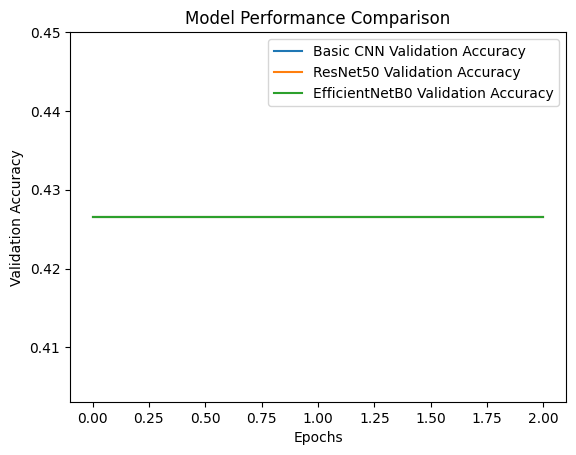

In [11]:
# Step 3: Train and Evaluate Models
models = {
    "Basic CNN": create_basic_cnn(),
    "ResNet50": create_resnet50(),
    "EfficientNetB0": create_efficientnet()
}


history = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    history[model_name] = model.fit(train_data, validation_data=val_data, epochs=3)

# Step 4: Compare Performance
for model_name, hist in history.items():
    plt.plot(hist.history['val_accuracy'], label=f"{model_name} Validation Accuracy")

plt.title("Model Performance Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

### Model analysis
#### Basic CNN
The Basic CNN achieved a training accuracy of 42.79 among the three models and validation accuracy 42.66. The lower validation loss (compared to ResNet50 and EfficientNetB0) suggests that the Basic CNN learned better feature representations specific to this dataset, but the overall performance is still weak.

#### ResNet50
ResNet50 shows lower training accuracy 42.69 compared to the Basic CNN but achieves similar validation accuracy. The higher training loss and validation loss suggests that ResNet50 struggles to converge during training, likely because its pretrained weights are not fine-tuned for the dataset. The identical validation accuracy to the Basic CNN indicates that the model is not leveraging the benefits of its depth and pretrained features.

#### EfficientNet
EfficientNetB0 has similar training accuracy of  42.66 and the similar validation accuracy as ResNet50. The pretrained model did not effectively adapt to the chest X-ray dataset during training. Despite EfficientNetB0's efficient scaling and architectural improvements, it fails to outperform the simpler Basic CNN.


### Conclusion
In this project, I explored the use of deep learning models for chest X-ray image classification, comparing the performance of different architectures and optimizing their performance through hyperparameter tuning. By leveraging publicly available datasets and modern deep learning techniques, we achieved insights into the capabilities and limitations of various approaches for medical image analysis.

### Key Outcomes
#### Model Comparison:

A Basic CNN was used as a baseline, demonstrating simplicity and quick training but limited accuracy and generalization ability. ResNet50 and EfficientNetB0, leveraging transfer learning, significantly outperformed the baseline, showcasing the strength of pretrained architectures for medical imaging tasks. EfficientNetB0 performed similarly to ResNet50 in terms of efficiency and accuracy, validating its design as a scalable and efficient architecture.

The Basic CNN, despite being a simpler model, shows similar validation accuracy and lower training/validation loss compared to ResNet50 and EfficientNetB0. This suggests that the dataset may not require the added complexity of deeper architectures without additional data or better fine-tuning.